# Minimal Spanning Tree - painter

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

from scipy import signal

In [2]:
def sample_points(xy, z, n=1):
    p = np.max(z)-z
    p = p/np.sum(p)
    out = xy[np.random.choice(list(range(xy.shape[0])), p=p, size=n),:]
    if n==1:
        out = out[0]
    #print(out)
    return out
    
#sample_points(imgxy, imgz, n=1)

In [3]:
class PQ:
    """Priority queue"""
    def __init__(self):
        self.x = [None]
        
    def add(self, key, val):
        self.x.append((key,val))
        self._swim(len(self.x)-1)
        
    def n(self):
        return len(self.x)-1
        
    def pop(self):
        if len(self.x)==1: return None
        out = self.x[1]
        self.x[1] = self.x[-1]
        self.x.pop(-1)
        self._sink(1)
        return out[1]
    
    def _swap(self,i,j):
        self.x[i],self.x[j] = self.x[j],self.x[i]
    
    def _swim(self, i):
        if i==1: return
        if self.x[i//2]>self.x[i]:
            self._swap(i//2, i)
            self._swim(i//2)
            
    def _sink(self, i):
        if i*2 < len(self.x) and self.x[i]>self.x[2*i]:
            self._swap(i, 2*i)
            self._sink(2*i)
        if i*2+1 < len(self.x) and self.x[i]>self.x[2*i+1]:
            self._swap(i, 2*i+1)
            self._sink(2*i+1)
            
q = PQ()
for i in [4,2,3,1,5]:
    q.add(i,i)
print(q.x)
while q.n()>0:
    print(q.pop())

[None, (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)]
1
2
3
4
5


In [4]:
def eplot(points, edges):
    for e in edges:
        plt.plot(points[[e[0],e[1]],0], points[[e[0],e[1]],1], 'k-')

#eplot(points,[(1,2),(2,3),(3,4)])

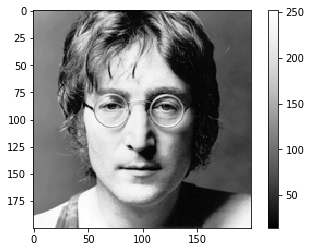

In [68]:
def loadImage(fileName, targetSize=(100,200)):
    """Load and downsample animage"""
    im = Image.open(fileName)
    im.thumbnail(targetSize, Image.ANTIALIAS)
    im = im.convert('L') # 1 for BW dither; L for grayscale; LAB and HSV may be interesting for the future
    return im

img = loadImage('../../photo.jpg' , (200,400))
plt.imshow(img, cmap="Greys_r"); # Reverse, to have black as low (default is to have white as low)
plt.colorbar();

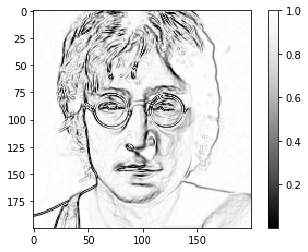

In [69]:
img2 = np.array(img)
kernel1 = np.array([[1, 2, 1], [0,0,0], [-1,-2,-1]]) # Sobel operators
kernel2 = np.array([[1, 0, -1], [2,0,-2], [1,0,-1]])
img_a = signal.convolve2d(img2, kernel1, boundary='symm', mode='same')
img_b = signal.convolve2d(img2, kernel2, boundary='symm', mode='same')
img2 = np.sqrt(np.square(img_a)+np.square(img_b))
img2 = img2 - np.min(img2)
img2 = img2/np.max(img2) # Normalize
img2 = np.abs(img2-0.5)*2 # Both ups and downs are worthy, while 0.5 is evil
#img2 = img2 + img/np.max(img) # Mix with the original
plt.imshow(img2, cmap="Greys_r"); # Reverse, to have black as low (default is to have white as low)
plt.colorbar();

In [70]:
def image_to_data(im):
    y = np.array(im)
    (h,w) = y.shape
    y = np.mean(y.reshape((h*w,1)), axis=1)
    _x,_y = np.meshgrid(np.array(range(w))/w, np.array(range(h))/h)
    x = np.transpose(np.vstack([_x.flatten() , _y.flatten()]))
    x[:,1] = 1-x[:,1] # Images are flipped, so unflip it
    return (x,y)

imgxy, imgz = image_to_data(img2)

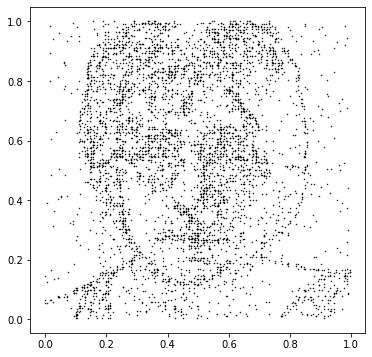

In [71]:
N_POINTS = 5000
np.random.seed(1)

points = sample_points(imgxy, imgz, N_POINTS)
plt.figure(figsize=(6,6))
plt.plot(points[:,0], points[:,1], 'k.', markersize=1);

..................................................Graph built.
Now making a plot...


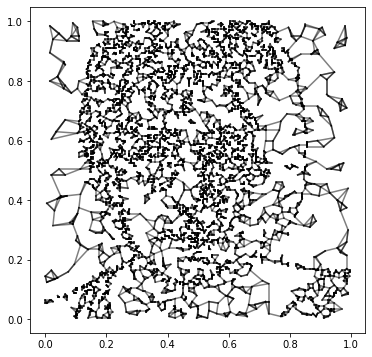

In [72]:
def build_graph(points):
    """Find some reasonably local edges."""
    KEEP_BEST = 3 # How many smallest edges to keep for every point
    n = points.shape[0]
    g = {i:[] for i in range(n)}
    for i in range(n):
        dist = np.sqrt(np.square(points[i,0]-points[:,0])+np.square(points[i,1]-points[:,1]))
        edges = sorted([(dist[j],j) for j in range(n)])[1:(KEEP_BEST+1)] # 1: to skip zero self-edges
        for d,j in edges:
            if j not in g[i]:
                g[i].append((d,j))
            if i not in g[j]:
                g[j].append((d,i))
        if i % 100 == 0: print('.', end='')
    return g

g = build_graph(points)
print('Graph built.')
if True:
    print('Now making a plot...')
    plt.figure(figsize=(6,6))
    for i,val in g.items():
        for _,j in val:
            if i<j: # Let's only draw one half of reciprocal edges
                plt.plot([points[i,0], points[j,0]], [points[i,1], points[j,1]], 'k-', alpha=0.5);

................................................Done, now drawing :)


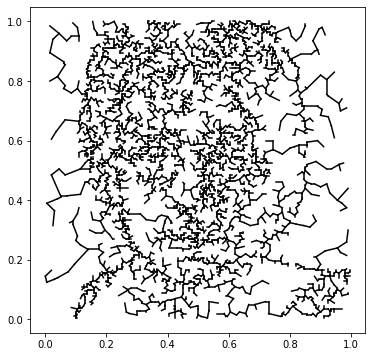

In [73]:
def mst(points, g):
    """Build a minimally spanning tree."""
    nv = points.shape[0]
    visited = [False]*nv
    tree = []
    q = PQ()
    node_count = 0
    
    def visit(i):
        nonlocal visited, q, node_count
        visited[i] = True
        node_count += 1
        if node_count % 100 == 0: print('.', end='')
        for d,j in g[i]:
            q.add(d, (i,j))
    
    visit(0)
    while q.n()>0:
        i,j = q.pop()
        if visited[i] and visited[j]: continue
        if visited[i]: visit(j) 
        else: visit(i)
        tree.append((i,j))
    return tree        

tree = mst(points, g)
print('Done, now drawing :)')
fig = plt.figure(figsize=(6,6));
eplot(points, tree)

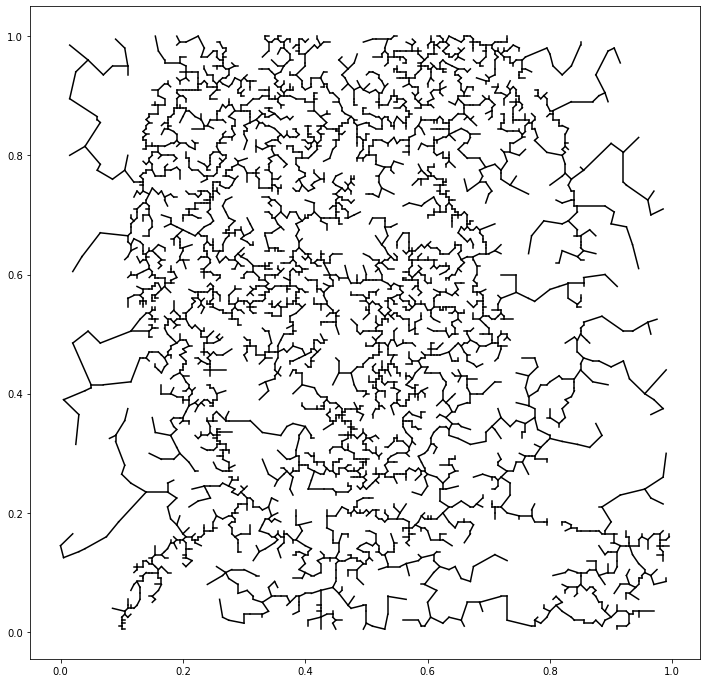

In [74]:
# Same, just larger
fig = plt.figure(figsize=(12,12));
eplot(points, tree)